## ***Initial Setup***

### ***Environment Setup***

In [0]:
import os
from pathlib import Path

In [0]:
DATA_DIR = Path('data/electricity')
MODEL_DIR = Path('model/electricity')

In [0]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

FIRST_RUN = not os.path.exists(str(MODEL_DIR))

In [0]:
if not IN_COLAB:
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [0]:
if FIRST_RUN:
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(DATA_DIR, exist_ok=True)

if IN_COLAB and FIRST_RUN:
    !pip install -q --upgrade scikit-optimize
    !pip install -q -U --pre efficientnet

### ***Kaggle Setup***

In [0]:
def setup_kaggle():
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Make sure you've uploaded 'kaggle.json' file into Colab
if IN_COLAB and FIRST_RUN:
    setup_kaggle()

In [0]:
import kaggle

In [0]:
if IN_COLAB and FIRST_RUN:
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(
        dataset='mvianna10/germany-electricity-power-for-20062017',
        path=DATA_DIR,
        unzip=True,
    )

### ***Importing Dependencies***

In [10]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [11]:
from imports import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
tf.__version__

'2.0.0'

In [0]:
if FIRST_RUN:
    exit()

## ***Dataset Description***

### **Content**

![PowerGrid](https://blog.malwarebytes.com/wp-content/uploads/2018/12/electricity-900x417.jpg)


Germany country-wide totals of electricity consumption, wind power production, and solar power production for 2006-2017.

This data was provided by Open Power System Data ([OPSD](https://open-power-system-data.org/)). You can find details about the origin source of this data and details about its accuracy [here](https://open-power-system-data.org/data-sources).

Electricity production and consumption are reported as daily totals in gigawatt-hours (GWh). The columns of the data file are:

* Date — The date (yyyy-mm-dd format)
* Consumption — Electricity consumption in GWh
* Wind — Wind power production in GWh
* Solar — Solar power production in GWh
* Wind+Solar — Sum of wind and solar power production in GWh

In [0]:
# Reading the data from the file
raw_data = pd.read_csv(DATA_DIR/'opsd_germany_daily.csv', low_memory=False, index_col=0, parse_dates=True)

In [15]:
raw_data.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


In [16]:
raw_data.tail()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2017-12-27,1263.94091,394.507,16.530,411.037
2017-12-28,1299.86398,506.424,14.162,520.586
2017-12-29,1295.08753,584.277,29.854,614.131
2017-12-30,1215.44897,721.247,7.467,728.714
2017-12-31,1107.11488,721.176,19.980,741.156


## ***Data Exploration***

In [17]:
print('Number of rows in the dataset:', raw_data.shape[0])
print('Number of columns in the dataset:', raw_data.shape[1])

Number of rows in the dataset: 4383
Number of columns in the dataset: 4


In [18]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2006-01-01 to 2017-12-31
Data columns (total 4 columns):
Consumption    4383 non-null float64
Wind           2920 non-null float64
Solar          2188 non-null float64
Wind+Solar     2187 non-null float64
dtypes: float64(4)
memory usage: 171.2 KB


In [0]:
# Add columns with year, month, day and date features
raw_data['Year'] = raw_data.index.year
raw_data['Month'] = raw_data.index.month
raw_data['Day'] = raw_data.index.day
raw_data['Weekday Name'] = raw_data.index.weekday_name
raw_data['Week No.'] = raw_data.index.weekofyear

In [20]:
# Null Values
null_vals = raw_data.isnull().sum().reset_index(name='Number of NaN values')
null_vals

,index,Number of NaN values
0,Consumption,0
1,Wind,1463
2,Solar,2195
3,Wind+Solar,2196
4,Year,0
5,Month,0
6,Day,0
7,Weekday Name,0
8,Week No.,0


In [21]:
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Consumption,4383.0,1338.675836,165.775710,842.395,1217.85900,1367.123,1457.76100,1709.568
Wind,2920.0,164.814173,143.692732,5.757,62.35325,119.098,217.90025,826.278
Solar,2188.0,89.258695,58.550099,1.968,35.17925,86.407,135.07150,241.580
Wind+Solar,2187.0,272.663481,146.319884,21.478,172.18550,240.991,338.98800,851.556
Year,4383.0,2011.500342,3.452347,2006.000,2008.50000,2012.000,2014.50000,2017.000
Month,4383.0,6.522930,3.449097,1.000,4.00000,7.000,10.00000,12.000
Day,4383.0,15.729637,8.801096,1.000,8.00000,16.000,23.00000,31.000
Week No.,4383.0,26.590463,15.063670,1.000,14.00000,27.000,40.00000,53.000


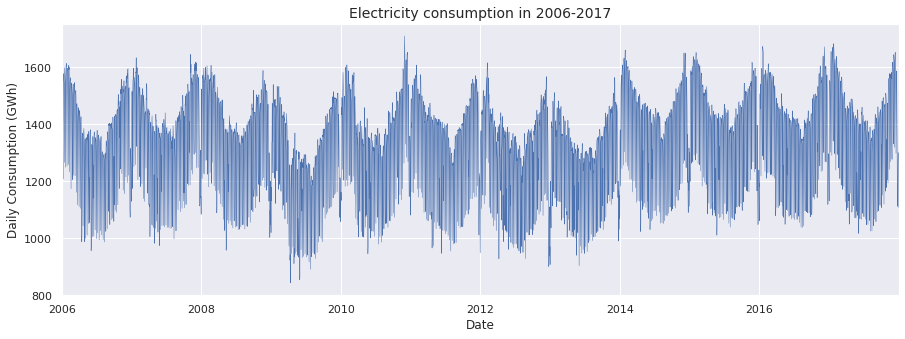

In [22]:
# setting plot style & size
sns.set(style='darkgrid')
plt.figure(figsize=(15, 5))

# adding chart title
plt.title('Electricity consumption in 2006-2017', size=14)

# adding custom labels for axes
plt.ylabel('Daily Consumption (GWh)')

# rendering plot
raw_data['Consumption'].plot(linewidth=0.5)

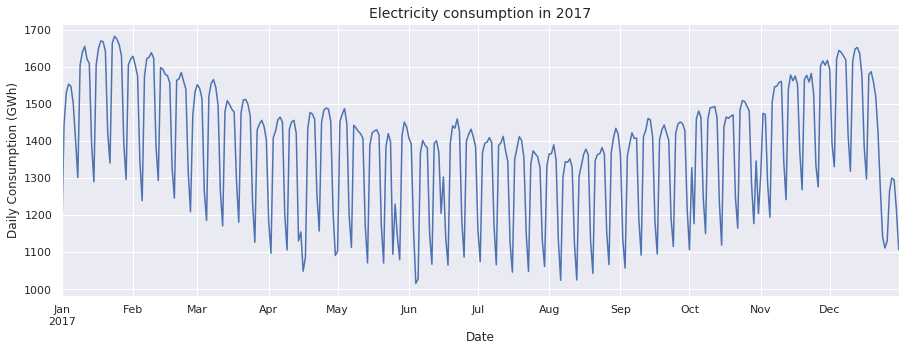

In [23]:
# setting plot style & size
sns.set(style='darkgrid')
plt.figure(figsize=(15, 5))

# adding chart title
plt.title('Electricity consumption in 2017', size=14)

# adding custom labels for axes
plt.ylabel('Daily Consumption (GWh)')

# rendering plot
raw_data.loc['2017', 'Consumption'].plot()

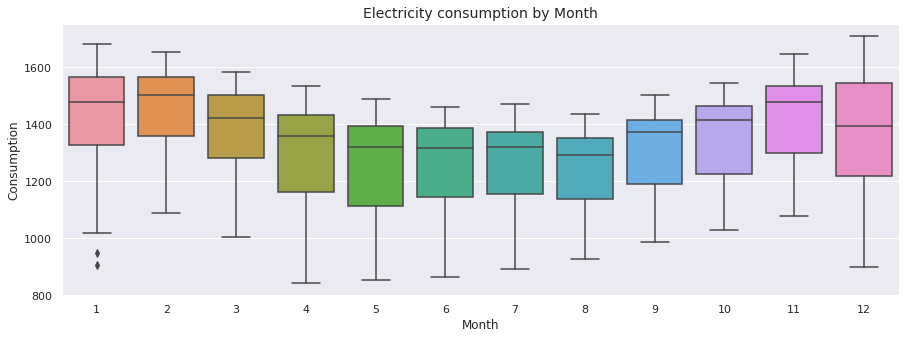

In [24]:
# setting plot style & size
sns.set(style='darkgrid')
plt.figure(figsize=(15, 5))

# adding chart title
plt.title('Electricity consumption by Month', size=14)

# adding custom labels for axes
plt.ylabel('Daily Consumption (GWh)')

# rendering plot
sns.boxplot(data=raw_data, x='Month', y='Consumption')

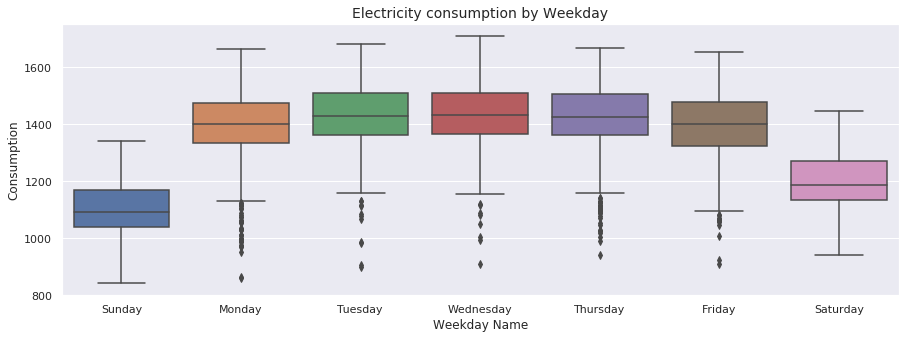

In [25]:
# setting plot style & size
sns.set(style='darkgrid')
plt.figure(figsize=(15, 5))

# adding chart title
plt.title('Electricity consumption by Weekday', size=14)

# adding custom labels for axes
plt.ylabel('Daily Consumption (GWh)')

# rendering plot
sns.boxplot(data=raw_data, x='Weekday Name', y='Consumption')

## ***Data Split - Train / Validation / Test***

In [0]:
work_data = raw_data.copy()

In [0]:
def data_split(data, size):
    # Data split part
    train_data = data.iloc[:-(size * 2)]
    val_data = data.iloc[size:-size]
    test_data = data.iloc[(size * 2):]
    
    # Data saving
    train_data.to_csv(path_or_buf=MODEL_DIR/'train_data.csv', index=True, header=True)
    val_data.to_csv(path_or_buf=MODEL_DIR/'val_data.csv', index=True, header=True)
    test_data.to_csv(path_or_buf=MODEL_DIR/'test_data.csv', index=True, header=True)
    
    return train_data, test_data, val_data

In [0]:
pred_length = 42

In [0]:
# val_size = pred_length * 2 / len(work_data)
train_data, test_data, val_data = data_split(work_data, pred_length)

In [30]:
[x.shape for x in (train_data, val_data, test_data)]

[(4299, 9), (4299, 9), (4299, 9)]

In [31]:
pd.concat([train_data.head(1), train_data.tail(1)])

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Day,Weekday Name,Week No.
Date,,,,,,,,,
2006-01-01,1069.1840,NaN,NaN,NaN,2006,1,1,Sunday,52
2017-10-08,1150.3125,302.855,61.004,363.859,2017,10,8,Sunday,40


In [32]:
pd.concat([val_data.head(1), val_data.tail(1)])

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Day,Weekday Name,Week No.
Date,,,,,,,,,
2006-02-12,1232.56800,NaN,NaN,NaN,2006,2,12,Sunday,6
2017-11-19,1268.00462,721.238,28.651,749.889,2017,11,19,Sunday,46


In [33]:
pd.concat([test_data.head(1), test_data.tail(1)])

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Day,Weekday Name,Week No.
Date,,,,,,,,,
2006-03-26,1116.74300,NaN,NaN,NaN,2006,3,26,Sunday,12
2017-12-31,1107.11488,721.176,19.98,741.156,2017,12,31,Sunday,52


## ***Data Preprocessing***

In [0]:
def nums_fit_transform(df, num_cols):
    df = df.copy()
    num_features_map = {}
    df[num_cols] = df[num_cols].astype(float)
    for num_col in num_cols:
        num_features_map[num_col] = {
            "mean": df[num_col].mean(),
            "std": df[num_col].std()
        }
        df[num_col] = (
            df[num_col] - num_features_map[num_col]["mean"]
        ) / num_features_map[num_col]["std"]
    return df, num_features_map

In [0]:
def nums_transform(df, num_features_map):
    df = df.copy()
    for num_col in num_features_map:
        df[num_col] = (
            df[num_col] - num_features_map[num_col]["mean"]
        ) / num_features_map[num_col]["std"]
    return df

In [0]:
num_cols = ['Consumption', 'Wind', 'Solar', 'Wind+Solar']
train_data, num_features_map = nums_fit_transform(train_data, num_cols)

In [0]:
with open(MODEL_DIR/'num_features_map.pkl', 'wb') as f:
    pickle.dump(num_features_map, f, pickle.HIGHEST_PROTOCOL)

In [0]:
val_data = nums_transform(val_data, num_features_map)
test_data = nums_transform(test_data, num_features_map)

In [39]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Consumption,4299.0,-2.206965e-14,1.000000,-2.989266,-0.732053,0.175291,0.717500,2.254517
Wind,2836.0,1.668701e-15,1.000000,-1.129028,-0.716542,-0.313276,0.396111,4.957723
Solar,2104.0,-1.296439e-15,1.000000,-1.532117,-0.926551,-0.024571,0.780415,2.570976
Wind+Solar,2103.0,2.377134e-15,1.000000,-1.761198,-0.687450,-0.201681,0.463222,4.209261
Year,4299.0,2.011393e+03,3.398376,2006.000000,2008.000000,2011.000000,2014.000000,2017.000000
Month,4299.0,6.433589e+00,3.420499,1.000000,3.000000,6.000000,9.000000,12.000000
Day,4299.0,1.570644e+01,8.805609,1.000000,8.000000,16.000000,23.000000,31.000000
Week No.,4299.0,2.620144e+01,14.940471,1.000000,13.000000,26.000000,39.000000,53.000000


In [40]:
val_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Consumption,4299.0,-0.003539,0.997365,-2.989266,-0.735521,0.173422,0.717062,2.254517
Wind,2878.0,0.018930,1.018543,-1.129028,-0.713289,-0.299055,0.422668,4.957723
Solar,2146.0,-0.013472,0.997290,-1.532117,-0.931098,-0.046455,0.761596,2.570976
Wind+Solar,2145.0,0.016580,1.014071,-1.761198,-0.682617,-0.193963,0.481304,4.209261
Year,4299.0,2011.500349,3.400064,2006.000000,2009.000000,2012.000000,2014.000000,2017.000000
Month,4299.0,6.523378,3.404224,1.000000,4.000000,7.000000,9.000000,12.000000
Day,4299.0,15.726913,8.792306,1.000000,8.000000,16.000000,23.000000,31.000000
Week No.,4299.0,26.581531,14.862752,1.000000,14.000000,27.000000,39.000000,53.000000


In [41]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Consumption,4299.0,-0.001816,1.001171,-2.989266,-0.737018,0.172340,0.714736,2.254517
Wind,2920.0,0.050883,1.065935,-1.129028,-0.709188,-0.288247,0.444683,4.957723
Solar,2188.0,-0.037359,1.002606,-1.532117,-0.963410,-0.086191,0.747135,2.570976
Wind+Solar,2187.0,0.045491,1.052427,-1.761198,-0.677212,-0.182318,0.522540,4.209261
Year,4299.0,2011.607816,3.398354,2006.000000,2009.000000,2012.000000,2015.000000,2017.000000
Month,4299.0,6.612701,3.419831,1.000000,4.000000,7.000000,10.000000,12.000000
Day,4299.0,15.751570,8.809903,1.000000,8.000000,16.000000,23.000000,31.000000
Week No.,4299.0,26.973715,14.932515,1.000000,14.000000,27.000000,40.000000,53.000000


## ***RNN Models***

#### ***Model Preparations and Utilities***

In [0]:
def get_labels(series, pred_length):
    n_labels = series.shape[1] - pred_length
    labels = np.empty((series.shape[0], n_labels, pred_length))
    for step_ahead in range(1, pred_length + 1):
        labels[..., step_ahead - 1] = series[..., step_ahead : step_ahead + n_labels, 0]
    return series[:, :-pred_length], labels

In [0]:
series_name = 'Consumption'

In [0]:
train_data, val_data, test_data = [
    series[series_name].values.reshape(1, -1, 1)
    for series in (train_data, val_data, test_data)
]

In [0]:
(train_data, train_labels), (val_data, val_labels), (test_data, test_labels) = [
    get_labels(series, pred_length)
    for series in (train_data, val_data, test_data)
]

In [46]:
[series.shape for series in (train_data, val_data, test_data)]

[(1, 4257, 1), (1, 4257, 1), (1, 4257, 1)]

In [47]:
[series.shape for series in (train_labels, val_labels, test_labels)]

[(1, 4257, 42), (1, 4257, 42), (1, 4257, 42)]

In [0]:
def plot_history(history, contains, skip=0):
    df = pd.DataFrame(history.history)
    df[list(df.filter(regex=contains))].iloc[skip:].plot()

In [0]:
def plot_timeseries(series, n_steps, y_true=None, y_pred=None):
    plt.plot(series, "o-")
    if y_true is not None:
        plt.plot(n_steps, y_true, "bo", markersize=8)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro", markersize=8)

In [0]:
def plot_predictions(data, labels, predictions):
    n_steps = data.shape[1]
    ahead = labels.shape[2]
        
    # setting plot style & size
    sns.set(style='darkgrid')
    plt.figure(figsize=(15, 5))

    # adding chart title
    plt.title('Electricity consumption forecast', size=14)

    # adding custom labels for axes
    plt.ylabel('Daily Consumption (GWh)')

    # rendering plot
    plot_timeseries(data[0, -ahead * 2 :, 0], ahead * 2)
    plt.plot(
        np.arange(ahead * 2, ahead * 3),
        labels[0, n_steps - 1, :],
        "ro-",
        label="Actual",
        markersize=5,
    )
    plt.plot(
        np.arange(ahead * 2, ahead * 3),
        predictions[0, n_steps - 1, :],
        "go-",
        label="Forecast",
        markersize=5,
    )

    plt.legend()

In [0]:
# Preparing to capture models & metrics
model_metrics = pd.DataFrame(columns=['MSE', 'MAE'])

In [0]:
patience = 50

In [0]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=patience * 2.5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=patience, factor=0.3, min_lr=3e-5),
]

#### ***RNN Model - LSTM layers***

In [0]:
model = keras.models.Sequential(
    [
        keras.layers.LSTM(256, return_sequences=True, input_shape=[None, 1]),
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.Dense(pred_length),
    ]
)

In [0]:
model.compile(
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
    optimizer=keras.optimizers.Adam(lr=1e-3),
)

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 256)         264192    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
dense (Dense)                (None, None, 42)          2730      
Total params: 513,450
Trainable params: 513,450
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(
    train_data,
    train_labels,
    validation_data=(val_data, val_labels),
    callbacks=callbacks,
    epochs=1000,
    verbose=2,
)

Train on 1 samples, validate on 1 samples
Epoch 1/1000
1/1 - 11s - loss: 1.0044 - mean_absolute_error: 0.8221 - val_loss: 0.9861 - val_mean_absolute_error: 0.8156
Epoch 2/1000
1/1 - 1s - loss: 0.9912 - mean_absolute_error: 0.8178 - val_loss: 0.9741 - val_mean_absolute_error: 0.8116
Epoch 3/1000
1/1 - 2s - loss: 0.9788 - mean_absolute_error: 0.8137 - val_loss: 0.9594 - val_mean_absolute_error: 0.8067
Epoch 4/1000
1/1 - 1s - loss: 0.9637 - mean_absolute_error: 0.8085 - val_loss: 0.9434 - val_mean_absolute_error: 0.8018
Epoch 5/1000
1/1 - 1s - loss: 0.9471 - mean_absolute_error: 0.8032 - val_loss: 0.9352 - val_mean_absolute_error: 0.8015
Epoch 6/1000
1/1 - 1s - loss: 0.9382 - mean_absolute_error: 0.8024 - val_loss: 0.9272 - val_mean_absolute_error: 0.8008
Epoch 7/1000
1/1 - 1s - loss: 0.9297 - mean_absolute_error: 0.8016 - val_loss: 0.9155 - val_mean_absolute_error: 0.7959
Epoch 8/1000
1/1 - 1s - loss: 0.9180 - mean_absolute_error: 0.7968 - val_loss: 0.9086 - val_mean_absolute_error: 0.79

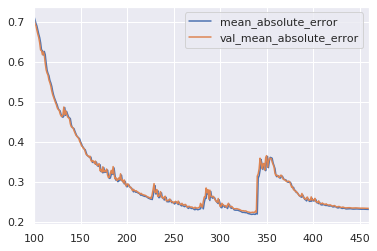

In [58]:
plot_history(history, 'mean_absolute_error', skip=100)

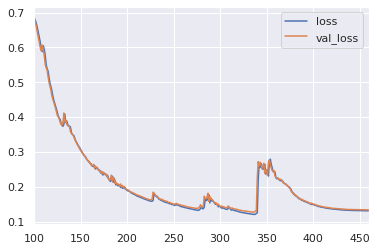

In [59]:
plot_history(history, 'loss', skip=100)

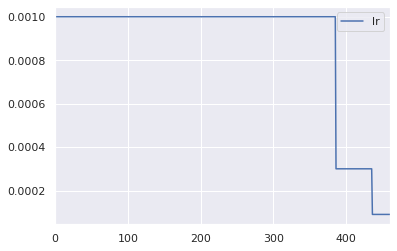

In [60]:
plot_history(history, 'lr')

In [0]:
val_preds = model.predict(val_data)

In [62]:
np.mean(keras.losses.mse(val_labels, val_preds))

0.12748955

In [0]:
model_name = 'LSTM'
model_metrics.loc[model_name, 'MSE'] = np.mean(keras.metrics.mse(val_labels, val_preds))
model_metrics.loc[model_name, 'MAE'] = np.mean(keras.metrics.mae(val_labels, val_preds))

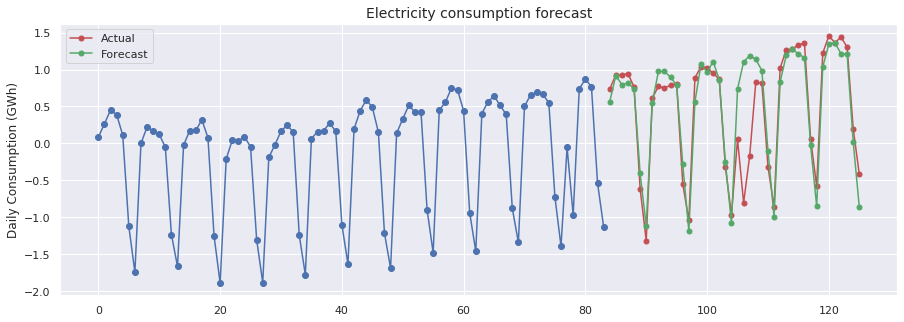

In [64]:
plot_predictions(val_data, val_labels, val_preds)

In [0]:
del model

#### ***RNN Model - GRU layers***

In [0]:
model = keras.models.Sequential(
    [
        keras.layers.GRU(256, return_sequences=True, input_shape=[None, 1]),
        keras.layers.GRU(128, return_sequences=True),
        keras.layers.GRU(64, return_sequences=True),
        keras.layers.Dense(pred_length),
    ]
)

In [0]:
model.compile(
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
    optimizer=keras.optimizers.Adam(lr=1e-3),
)

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 256)         198912    
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         148224    
_________________________________________________________________
gru_2 (GRU)                  (None, None, 64)          37248     
_________________________________________________________________
dense_1 (Dense)              (None, None, 42)          2730      
Total params: 387,114
Trainable params: 387,114
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit(
    train_data,
    train_labels,
    validation_data=(val_data, val_labels),
    callbacks=callbacks,
    epochs=1000,
    verbose=2,
)

Train on 1 samples, validate on 1 samples
Epoch 1/1000
1/1 - 7s - loss: 1.0087 - mean_absolute_error: 0.8236 - val_loss: 0.9818 - val_mean_absolute_error: 0.8148
Epoch 2/1000
1/1 - 2s - loss: 0.9868 - mean_absolute_error: 0.8170 - val_loss: 0.9640 - val_mean_absolute_error: 0.8088
Epoch 3/1000
1/1 - 2s - loss: 0.9684 - mean_absolute_error: 0.8108 - val_loss: 0.9466 - val_mean_absolute_error: 0.8032
Epoch 4/1000
1/1 - 2s - loss: 0.9505 - mean_absolute_error: 0.8050 - val_loss: 0.9288 - val_mean_absolute_error: 0.7980
Epoch 5/1000
1/1 - 1s - loss: 0.9321 - mean_absolute_error: 0.7994 - val_loss: 0.9121 - val_mean_absolute_error: 0.7933
Epoch 6/1000
1/1 - 1s - loss: 0.9147 - mean_absolute_error: 0.7944 - val_loss: 0.8998 - val_mean_absolute_error: 0.7898
Epoch 7/1000
1/1 - 1s - loss: 0.9019 - mean_absolute_error: 0.7905 - val_loss: 0.8934 - val_mean_absolute_error: 0.7882
Epoch 8/1000
1/1 - 1s - loss: 0.8951 - mean_absolute_error: 0.7885 - val_loss: 0.8870 - val_mean_absolute_error: 0.786

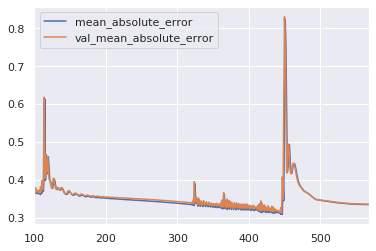

In [70]:
plot_history(history, 'mean_absolute_error', skip=100)

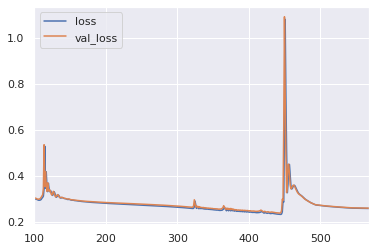

In [71]:
plot_history(history, 'loss', skip=100)

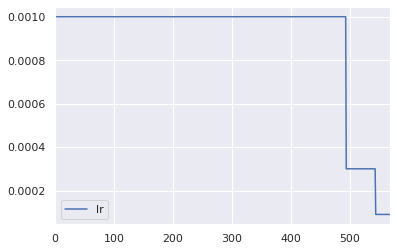

In [72]:
plot_history(history, 'lr')

In [0]:
val_preds = model.predict(val_data)

In [74]:
np.mean(keras.losses.mse(val_labels, val_preds))

0.23721565

In [0]:
model_name = 'GRU'
model_metrics.loc[model_name, 'MSE'] = np.mean(keras.metrics.mse(val_labels, val_preds))
model_metrics.loc[model_name, 'MAE'] = np.mean(keras.metrics.mae(val_labels, val_preds))

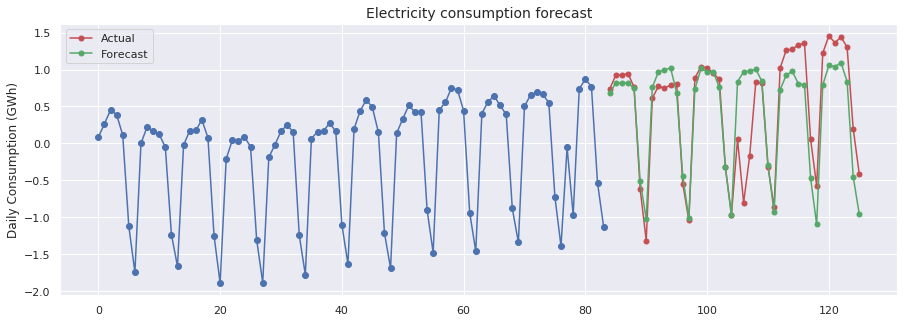

In [77]:
plot_predictions(val_data, val_labels, val_preds)

In [0]:
del model

#### ***RNN Model - Convolutional layers***

In [0]:
model = keras.models.Sequential(
    [
        keras.layers.Conv1D(filters=256, kernel_size=8, padding="same", input_shape=[None, 1]),
        keras.layers.Conv1D(filters=128, kernel_size=8, padding="same"),
        keras.layers.Conv1D(filters=64, kernel_size=8, padding="same"),
        # keras.layers.Conv1D(filters=pred_length, kernel_size=8, padding="same"),
        keras.layers.Dense(pred_length),
    ]
)

In [0]:
model.compile(
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
    optimizer=keras.optimizers.Adam(lr=1e-3),
)

In [81]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 256)         2304      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         262272    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          65600     
_________________________________________________________________
dense_2 (Dense)              (None, None, 42)          2730      
Total params: 332,906
Trainable params: 332,906
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = model.fit(
    train_data,
    train_labels,
    validation_data=(val_data, val_labels),
    callbacks=callbacks,
    epochs=1000,
    verbose=2,
)

Train on 1 samples, validate on 1 samples
Epoch 1/1000
1/1 - 1s - loss: 1.0025 - mean_absolute_error: 0.8206 - val_loss: 0.7417 - val_mean_absolute_error: 0.7024
Epoch 2/1000
1/1 - 0s - loss: 0.7441 - mean_absolute_error: 0.7037 - val_loss: 0.5885 - val_mean_absolute_error: 0.6076
Epoch 3/1000
1/1 - 0s - loss: 0.5892 - mean_absolute_error: 0.6080 - val_loss: 0.5047 - val_mean_absolute_error: 0.5405
Epoch 4/1000
1/1 - 0s - loss: 0.5045 - mean_absolute_error: 0.5404 - val_loss: 0.4632 - val_mean_absolute_error: 0.5020
Epoch 5/1000
1/1 - 0s - loss: 0.4625 - mean_absolute_error: 0.5018 - val_loss: 0.4325 - val_mean_absolute_error: 0.4769
Epoch 6/1000
1/1 - 0s - loss: 0.4317 - mean_absolute_error: 0.4765 - val_loss: 0.4053 - val_mean_absolute_error: 0.4594
Epoch 7/1000
1/1 - 0s - loss: 0.4044 - mean_absolute_error: 0.4591 - val_loss: 0.3844 - val_mean_absolute_error: 0.4471
Epoch 8/1000
1/1 - 0s - loss: 0.3836 - mean_absolute_error: 0.4467 - val_loss: 0.3686 - val_mean_absolute_error: 0.436

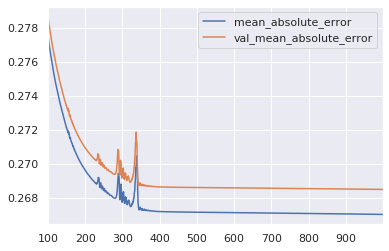

In [83]:
plot_history(history, 'mean_absolute_error', skip=100)

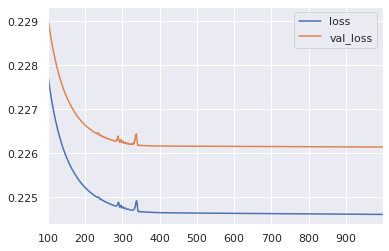

In [84]:
plot_history(history, 'loss', skip=100)

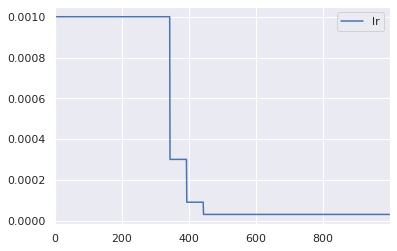

In [85]:
plot_history(history, 'lr')

In [0]:
val_preds = model.predict(val_data)

In [87]:
np.mean(keras.losses.mse(val_labels, val_preds))

0.22614393

In [0]:
model_name = 'Convs'
model_metrics.loc[model_name, 'MSE'] = np.mean(keras.metrics.mse(val_labels, val_preds))
model_metrics.loc[model_name, 'MAE'] = np.mean(keras.metrics.mae(val_labels, val_preds))

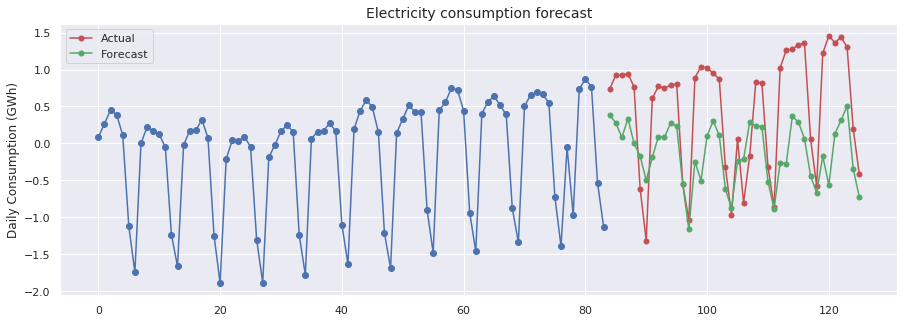

In [89]:
plot_predictions(val_data, val_labels, val_preds)

In [0]:
del model

#### ***RNN Model - Hybrid layers***

In [0]:
model = keras.models.Sequential(
    [
        keras.layers.Conv1D(filters=256, kernel_size=8, padding="same", input_shape=[None, 1]),
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.GRU(64, return_sequences=True),
        keras.layers.Dense(pred_length),
    ]
)

In [0]:
model.compile(
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
    optimizer=keras.optimizers.Adam(lr=1e-3),
)

In [93]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 256)         2304      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 128)         197120    
_________________________________________________________________
gru_3 (GRU)                  (None, None, 64)          37248     
_________________________________________________________________
dense_3 (Dense)              (None, None, 42)          2730      
Total params: 239,402
Trainable params: 239,402
Non-trainable params: 0
_________________________________________________________________


In [94]:
history = model.fit(
    train_data,
    train_labels,
    validation_data=(val_data, val_labels),
    callbacks=callbacks,
    epochs=1000,
    verbose=2,
)

Train on 1 samples, validate on 1 samples
Epoch 1/1000
1/1 - 5s - loss: 1.0070 - mean_absolute_error: 0.8233 - val_loss: 0.9765 - val_mean_absolute_error: 0.8125
Epoch 2/1000
1/1 - 1s - loss: 0.9813 - mean_absolute_error: 0.8146 - val_loss: 0.9554 - val_mean_absolute_error: 0.8054
Epoch 3/1000
1/1 - 1s - loss: 0.9596 - mean_absolute_error: 0.8073 - val_loss: 0.9348 - val_mean_absolute_error: 0.7987
Epoch 4/1000
1/1 - 1s - loss: 0.9384 - mean_absolute_error: 0.8003 - val_loss: 0.9150 - val_mean_absolute_error: 0.7925
Epoch 5/1000
1/1 - 1s - loss: 0.9179 - mean_absolute_error: 0.7937 - val_loss: 0.8981 - val_mean_absolute_error: 0.7877
Epoch 6/1000
1/1 - 1s - loss: 0.9005 - mean_absolute_error: 0.7886 - val_loss: 0.8856 - val_mean_absolute_error: 0.7852
Epoch 7/1000
1/1 - 1s - loss: 0.8874 - mean_absolute_error: 0.7857 - val_loss: 0.8751 - val_mean_absolute_error: 0.7835
Epoch 8/1000
1/1 - 1s - loss: 0.8765 - mean_absolute_error: 0.7838 - val_loss: 0.8642 - val_mean_absolute_error: 0.780

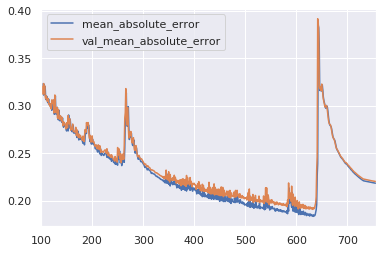

In [95]:
plot_history(history, 'mean_absolute_error', skip=100)

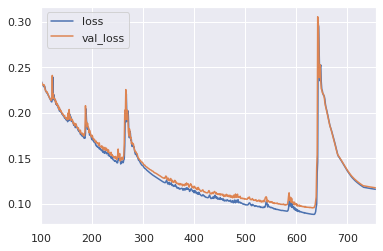

In [96]:
plot_history(history, 'loss', skip=100)

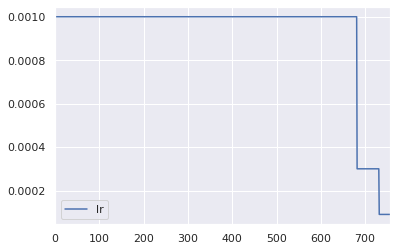

In [97]:
plot_history(history, 'lr')

In [0]:
val_preds = model.predict(val_data)

In [99]:
np.mean(keras.losses.mse(val_labels, val_preds))

0.09570219

In [0]:
model_name = 'Hybrid'
model_metrics.loc[model_name, 'MSE'] = np.mean(keras.metrics.mse(val_labels, val_preds))
model_metrics.loc[model_name, 'MAE'] = np.mean(keras.metrics.mae(val_labels, val_preds))

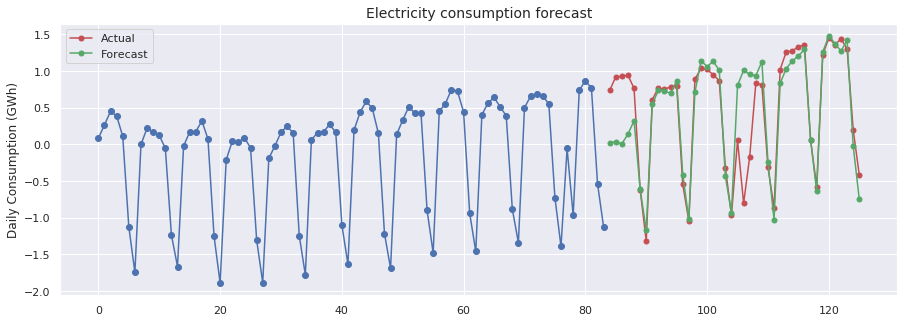

In [101]:
plot_predictions(val_data, val_labels, val_preds)

In [0]:
del model

In [103]:
model_metrics

,MSE,MAE
LSTM,0.12749,0.223471
GRU,0.237216,0.318529
Convs,0.226144,0.268489
Hybrid,0.0957022,0.19147
